In [ ]:
"""
A demonstration on Merging, Rebinning, and Smoothing using xraylarch

Source codes from xraylarch's github:

Merging: https://github.com/xraypy/xraylarch/blob/master/larch/io/mergegroups.py
Rebinning: https://github.com/xraypy/xraylarch/blob/master/larch/xafs/rebin_xafs.py
Smoothing: https://github.com/xraypy/xraylarch/blob/master/larch/math/utils.py

"""

In [1]:
# Import general packages
import os
import matplotlib.pyplot as plt

# Custom modules to read photon factory formatted data
from tools import io_photon_factory as io_pf

# Larch packages for analysis
from larch.xafs import autobk, xftf

[root] WARNING : Larchs apps and shell are not supported due to missing dependencies: cannot import name 'LarchWxApp' from 'larch.wxlib' (D:\Python\Anaconda3\envs\xraylarch\lib\site-packages\larch\wxlib\__init__.py)


In [2]:
""" 
Loading example data 

Material: carbon supported low Pt loading PtNi nanoparticles
Data: A series of Pt L edge spectra measured in situ at 0.4 V in Photon Factory 

"""

data_folder = r"data\PtL_PtNi25_0.4V" 
fpaths_pot04 = [os.path.join(data_folder, fpath) for fpath in os.listdir(data_folder)]
data_pot04 = [io_pf.read_fluor(fpath) for fpath in fpaths_pot04] # list of data groups loaded using custom modules
data_pot04 = data_pot04[1:] # Remove the first spectrum because its glitchy

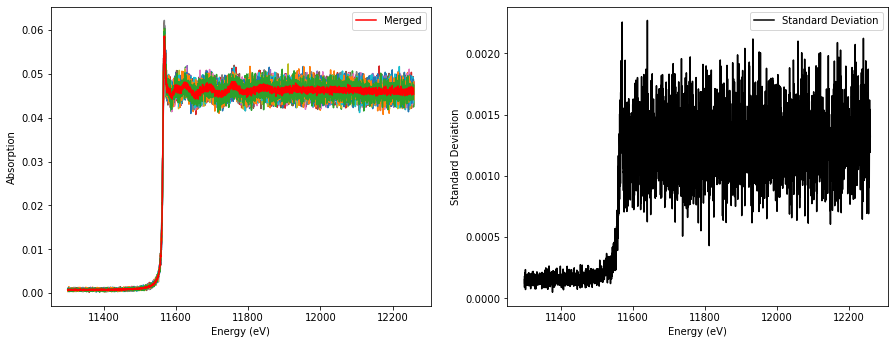

In [3]:
""" 
Merging Data
https://github.com/xraypy/xraylarch/blob/master/larch/io/mergegroups.py

It uses the energy values of a "master" spectrum and interpolate for every spectrum in the merging group,
so that the all absorption values of all spectra correspond to the same array of energy values.
Then computes averages of the absorption values, and the standard deviation.

"""
from larch.io import merge_groups

# Merge group: takes a list of data group and return a merged spectrum
merged_pot04 = merge_groups(data_pot04)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5.5))

for data in data_pot04:
    ax[0].plot(data.energy, data.mu)
ax[0].plot(merged_pot04.energy, merged_pot04.mu, color="r", label="Merged")
ax[1].plot(merged_pot04.energy, merged_pot04.mu_std, color="k", label="Standard Deviation")
    
# Axis labels
ax[0].set_xlabel("Energy (eV)")
ax[0].set_ylabel("Absorption")

ax[1].set_xlabel("Energy (eV)")
ax[1].set_ylabel("Standard Deviation")

# Legends
for i in range(2):
    ax[i].legend()

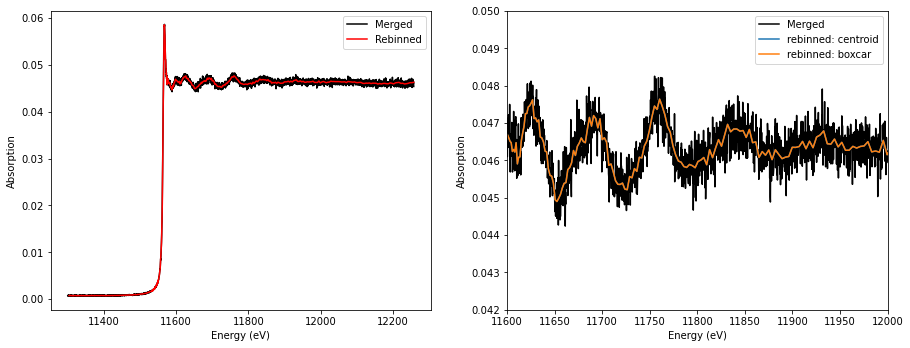

In [4]:
"""
Rebinning Data
https://github.com/xraypy/xraylarch/blob/master/larch/xafs/rebin_xafs.py

Rebin XAFS energy and mu to a 'standard 3 region XAFS scan'
Default: step region: -30 to 15 eV from e0

Rebin could be done in 3 possible ways:
1. linear interpolation
2. mean values ("boxcar")
3. centroid ("centroid")

"""
from larch.xafs import rebin_xafs

autobk(merged_pot04) # autobk to compute e0 for rebinning
rebin_xafs(merged_pot04, method="centroid")
rebinned = merged_pot04.rebinned # rebinned data is stored as a group "rebinned" within the original data group

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5.5))

ax[0].plot(merged_pot04.energy, merged_pot04.mu, color="k", label="Merged")
ax[0].plot(rebinned.energy, rebinned.mu, color="r", label="Rebinned")

ax[1].plot(merged_pot04.energy, merged_pot04.mu, color="k", label="Merged")

for method in ["centroid", "boxcar"]:
    rebin_xafs(merged_pot04, method=method)
    ax[1].plot(merged_pot04.rebinned.energy, merged_pot04.rebinned.mu, label=f"rebinned: {method}")

# Axis labels and ranges
for i in range(2):
    ax[i].set_xlabel("Energy (eV)")
    ax[i].set_ylabel("Absorption")

ax[1].set_xlim(11600, 12000)
ax[1].set_ylim(0.042, 0.05)

# Legends
for i in range(2):
    ax[i].legend()

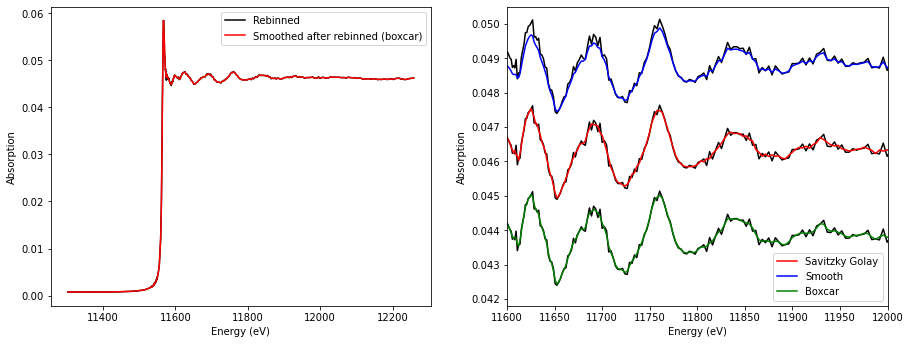

In [5]:
"""
Smoothing Data
https://github.com/xraypy/xraylarch/blob/master/larch/math/utils.py

xraylarch offers 3 different routines for smoothing:
1. savitzky_golay
2. smooth
3. boxcar

There are plenty of arguments for each smooth type, see github link for more info 

"""
from larch.math import smoothing

# Smoothing routines return an array of absorption values instead of storing inside the group
y_sg = smoothing.savitzky_golay(rebinned.mu, window_size=3, order=1)
y_sm = smoothing.smooth(rebinned.energy, rebinned.mu)
y_bc = smoothing.boxcar(rebinned.mu)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5.5))

ax[0].plot(rebinned.energy, rebinned.mu, color="k", label="Rebinned")
ax[0].plot(rebinned.energy, y_bc, color="r", label="Smoothed after rebinned (boxcar)")

ax[1].plot(rebinned.energy, rebinned.mu, color="k")
ax[1].plot(rebinned.energy, y_sg, color="r", label="Savitzky Golay")

ax[1].plot(rebinned.energy, rebinned.mu + 0.0025, color="k")
ax[1].plot(rebinned.energy, y_sm + 0.0025, color="b", label="Smooth")

ax[1].plot(rebinned.energy, rebinned.mu - 0.0025, color="k")
ax[1].plot(rebinned.energy, y_bc - 0.0025, color="g", label="Boxcar")

# Axis labels and ranges
for i in range(2):
    ax[i].set_xlabel("Energy (eV)")
    ax[i].set_ylabel("Absorption")

ax[1].set_xlim(11600, 12000)
ax[1].set_ylim(0.0418, 0.0505)

# Legends
for i in range(2):
    ax[i].legend()

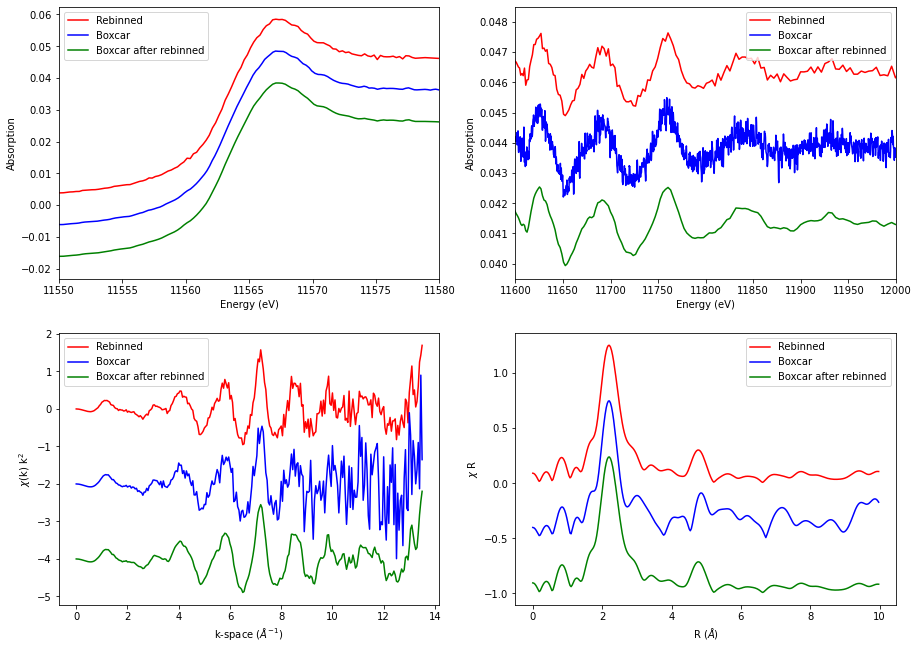

In [6]:
""" Comparison """
from larch import Group

# Rebinning
autobk(merged_pot04) # autobk to compute e0 for rebinning
rebin_xafs(merged_pot04, method="centroid")
rebinned = merged_pot04.rebinned 

# Smoothing using boxcar before rebinning
mu_boxcar = smoothing.boxcar(merged_pot04.mu)
smooth = Group(name="Smooth", energy=merged_pot04.energy, mu=mu_boxcar) # Create a new group to stored smoothed data

# Smoothing using boxcar after rebinning
mu_boxcar_rebinned = smoothing.boxcar(rebinned.mu)
smooth_rebinned = Group(name="SmoothRebinned", energy=rebinned.energy, mu=mu_boxcar_rebinned) 

# Normalisation and forward FT
for data in [rebinned, smooth, smooth_rebinned]:
    autobk(data)
    xftf(data, kmin=3.0, kmax=12, dk=1.0, window="hanning", kweight=2.00)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 11))
axes = ax.ravel()

ax[0, 0].plot(rebinned.energy, rebinned.mu, color="r", label="Rebinned")
ax[0, 0].plot(smooth.energy, smooth.mu - 0.01, color="b", label="Boxcar")
ax[0, 0].plot(smooth_rebinned.energy, smooth_rebinned.mu - 0.02, color="g", label="Boxcar after rebinned")

ax[0, 1].plot(rebinned.energy, rebinned.mu, color="r", label="Rebinned")
ax[0, 1].plot(smooth.energy, smooth.mu - 0.0025, color="b", label="Boxcar")
ax[0, 1].plot(smooth_rebinned.energy, smooth_rebinned.mu - 0.005, color="g", label="Boxcar after rebinned")

ax[1, 0].plot(rebinned.k, rebinned.chi * rebinned.k ** 2, color="r", label="Rebinned")
ax[1, 0].plot(smooth.k, smooth.chi * smooth.k ** 2 - 2, color="b", label="Boxcar")
ax[1, 0].plot(smooth_rebinned.k, smooth_rebinned.chi * smooth_rebinned.k ** 2 - 4, color="g", label="Boxcar after rebinned")

ax[1, 1].plot(rebinned.r, rebinned.chir_mag, color="r", label="Rebinned")
ax[1, 1].plot(smooth.r, smooth.chir_mag - 0.5, color="b", label="Boxcar")
ax[1, 1].plot(smooth_rebinned.r, smooth_rebinned.chir_mag - 1, color="g", label="Boxcar after rebinned")

# Axis labels and ranges
for axe in axes[:2]:
    axe.set_xlabel("Energy (eV)")
    axe.set_ylabel("Absorption")

ax[1, 0].set_xlabel("k-space ($\AA^{-1}$)")
ax[1, 0].set_ylabel("$\chi$(k) k$^2$")

ax[1, 1].set_xlabel("R ($\AA$)")
ax[1, 1].set_ylabel("$\chi$ R")


ax[0, 0].set_xlim(11550, 11580)
ax[0, 1].set_xlim(11600, 12000)
ax[0, 1].set_ylim(0.0395, 0.0485)

# Legends
for axe in axes:
    axe.legend()